    
# DATA DAY TRAINING: Intro to Python (data science workflow)

Topics to cover:

(i) Import data (from web and CSV files)

(ii) Clean and merge datasets

(iii) Exploratory data analysis

(iv) Visualization and modelling

We will cover this topic while exploring how life satisfaction in OECD countries varies with GNI per capita.

#### 1. Import libraries

Python provides several ways to import modules:

- import XYZ as x (to import the library XYZ abbreviated as x)
- import XYZ.xyz as x (to import module xyz (abbreviated as x from the library XYZ) 
- from XYZ import a, b, c (to import modules a, b, and c from library XYZ) 


You will notice pandas as one of the libraries we have imported along with some others.

Pandas is an open source library that has become the de facto tool in Python for data munging. Pandas allows us to present data in a tabular form with rows and columns (by storing data in a python object called a dataframe)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import wb
#import numpy as np
#import statsmodels.api as sm
from matplotlib.pyplot import figure
#import geopandas as gpd

#### 1.1 Quick demo of pulling WDI data from the web
We're using Pandas Datareader: a third-party library that makes it easy to pull data from APIs into a Pandas dataframe.

Use it to pull live data from Yahoo! Finance, World Bank and others.


| Function | Task Performed |
|----|---|
| wb.get_countries()  | List available countries, with their country codes, income levels etc. |
| wb.search()  | Query the available indicators using a search term. |
| wb.WorldBankReader()  | A class for downloading data series. |


In [2]:
# Find the GNI per capita indicator, get its ID number

result = wb.search(string="GNI per capita, Atlas",field = 'name')
result

,id,name,source,sourceNote,sourceOrganization,topics,unit
8496,NY.GNP.PCAP.CD,"GNI per capita, Atlas method (current US$)",World Development Indicators,GNI per capita (formerly GNP per capita) is th...,"b'World Bank national accounts data, and OECD ...",Economy & Growth,


In [3]:
# Make a note of the indicator ID
GNI_ID = 'NY.GNP.PCAP.CD'

In [4]:
# Get a list of countries and clean it up
countries = wb.get_countries()
countries.head()

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region
0,,Oranjestad,ABW,High income,AW,12.51670,Not classified,-70.0167,Aruba,Latin America & Caribbean
1,South Asia,Kabul,AFG,Low income,AF,34.52280,IDA,69.1761,Afghanistan,South Asia
2,,,AFR,Aggregates,A9,NaN,Aggregates,NaN,Africa,Aggregates
3,Sub-Saharan Africa (excluding high income),Luanda,AGO,Lower middle income,AO,-8.81155,IBRD,13.2420,Angola,Sub-Saharan Africa
4,Europe & Central Asia (excluding high income),Tirane,ALB,Upper middle income,AL,41.33170,IBRD,19.8172,Albania,Europe & Central Asia


In [5]:
#Select only those observations and columns we need: 
countries = countries[countries.incomeLevel != 'Aggregates']
countries = countries[['name', 'iso3c','incomeLevel']]
countries.head()

,name,iso3c,incomeLevel
0,Aruba,ABW,High income
1,Afghanistan,AFG,Low income
3,Angola,AGO,Lower middle income
4,Albania,ALB,Upper middle income
5,Andorra,AND,High income


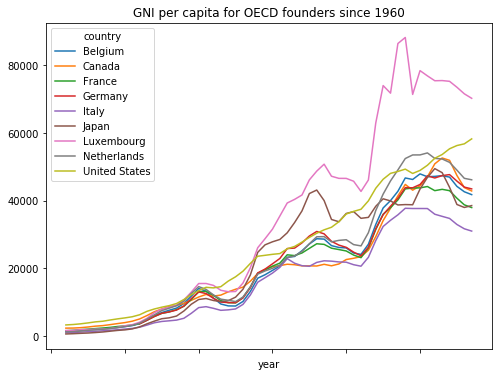

In [6]:
# Let's plot GNI per capita since 1960 for the OECD countries

OECD_founders = ['Belgium','France','Germany','Italy','Luxembourg','Netherlands','United States',
                'Canada','Japan']
OECD_founder_codes = countries.iso3c[countries.name.isin(OECD_founders)]

# Create a reader object, pass it the data ID and country codes we want

reader = wb.WorldBankReader(symbols=GNI_ID,countries = OECD_founder_codes,start=1960)
GNI_capita = reader.read()
GNI_capita.head()

GNI_capita = GNI_capita.unstack(level=0)[GNI_ID]
GNI_capita.head()

GNI_capita.plot(figsize=[8,6])
plt.title('GNI per capita for OECD founders since 1960');

#### 2. Combine income and life satisfaction data for 2015
Incomes have risen sharply. But does that translate into more life satisfaction, and are richer countries happier?

Let's do a cross-sectional analysis for a single year. 

#### 2.1 Import and clean up the OECD life satisfaction survey

In [7]:
# Read data from a CSV file using Pandas

CSV_path = 'https://raw.githubusercontent.com/worldbank/python-101/master/notebooks/BLI2015.csv'
life_sat = pd.read_csv(CSV_path)

In [8]:
# Keep relevant observations and columns discarding the rest

life_sat = life_sat[(life_sat.Inequality == "Total") & (life_sat.Indicator == 'Life satisfaction')]
life_sat = life_sat[['Country','LOCATION','Value']]

In [9]:
# Remove two values that don't match across datasets

life_sat = life_sat[~life_sat.Country.str.contains("OECD")]
life_sat = life_sat[~life_sat.Country.str.contains("Korea")]

# Rename columns
life_sat.rename(columns = {'Country': 'country', 'LOCATION':'iso3c', 'Value':'life_satisfaction'},inplace=True)

In [10]:
# Inspect the dataframe: 
life_sat.head()

,country,iso3c,life_satisfaction
2669,Australia,AUS,7.3
2670,Austria,AUT,6.9
2671,Belgium,BEL,6.9
2672,Canada,CAN,7.3
2673,Czech Republic,CZE,6.5


#### 2.2 Get GNI per capita for OECD countries in 2015

In [11]:
# Read in the data

OECD_country_codes = life_sat.iso3c
reader = wb.WorldBankReader(symbols = GNI_ID, countries = OECD_country_codes, start = 2015, end = 2015)
GNI_OECD = reader.read()


In [12]:
# Clean up the dataframe and rename column

GNI_OECD2 = GNI_OECD.reset_index()
GNI_OECD = GNI_OECD2
GNI_OECD.rename(columns={'NY.GNP.PCAP.CD':'GNI_per_capita'},inplace=True)

In [13]:
#Inspect the dataframe

GNI_OECD.head()

,country,year,GNI_per_capita
0,Australia,2015,60360
1,Austria,2015,47630
2,Belgium,2015,44230
3,Brazil,2015,10090
4,Canada,2015,47460


#### 2.3 Merge the datasets

In [14]:
# Merge the datasets, keeping only the columns we need
df = pd.merge(life_sat, GNI_OECD,on='country')
df = df[['country','life_satisfaction','GNI_per_capita']]

In [15]:
# Inspect the dataframe 
df.head()

,country,life_satisfaction,GNI_per_capita
0,Australia,7.3,60360
1,Austria,6.9,47630
2,Belgium,6.9,44230
3,Canada,7.3,47460
4,Czech Republic,6.5,18250


### 3. Visualize a scatterplot

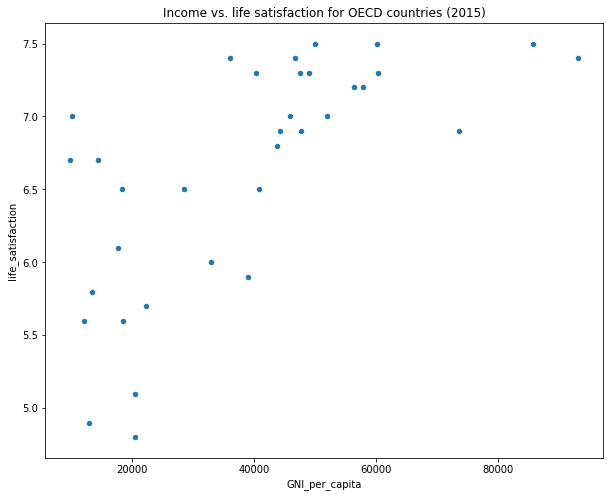

In [16]:
#Scatterplot income vs life satisfaction
fig,ax = plt.subplots(figsize = [10,8])
df.plot(kind='scatter',x='GNI_per_capita',y='life_satisfaction',ax=ax)
plt.title('Income vs. life satisfaction for OECD countries (2015)');

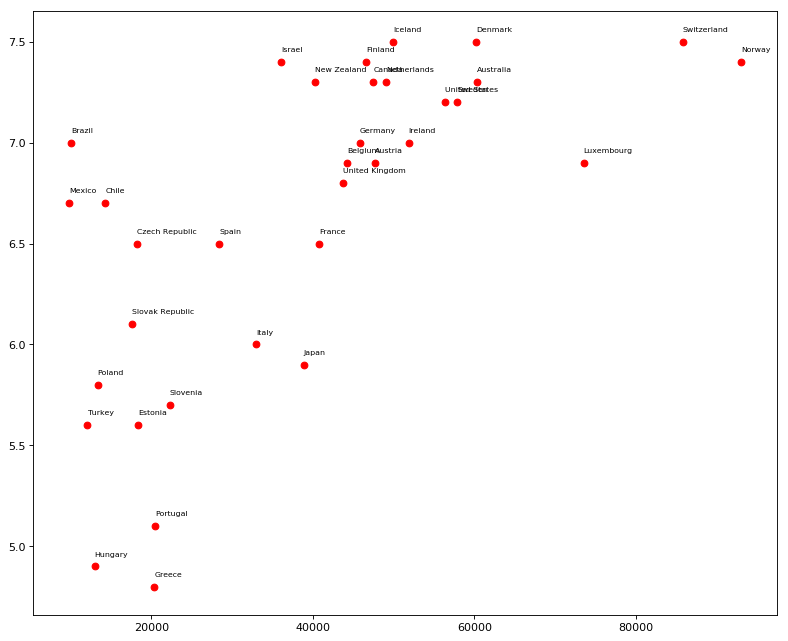

In [17]:
#With annotated data points 

countrylist=df.iloc[:, 0].tolist()
lifesat=df.iloc[:, 1].tolist()
GNIpercapita=df.iloc[:,2].tolist()
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
for i,type in enumerate(countrylist):
    inc = GNIpercapita[i]
    lif = lifesat[i]
    plt.scatter(inc, lif, color='red')
    plt.text(inc+0.05, lif+0.05, type, fontsize=7)
plt.show()

## EXERCISES:

We have looked at the tools Python has for data processing and cleaning, 
now lets explore the available functionality for statistical exploration of the data. 
At this stage, we can use common pandas functions and do things like:

- check the shape of the dataframe, i.e. number of rows and columns *df.shape*
- check the names of the columns *df.columns*
- display the first n observations in a dataframe *df.head(n)* (default is n=5)
- checking data types: *df.dtypes*
- accessing/indexing columns. Two main ways: *df.column_name* or *df[column_name]*
- check distribution of the variables using *df.describe()*
- check summary statistics using *df.mean()* or *df.median()* or *df.min* or *df.max*
- get value counts, mostly useful for categorical variables: *df[col_name].value_counts()*
- sort the data: *df.sort_values*

In case you need to know what each function does in pandas, use this trick to get details: df.function_name?. Try this without including the brackets/parentheses to get documentation about that particular function





Exercise 1: Display descriptive Statistics for the whole dataset (using dataframe.describe()

In [18]:
#Your code here: 


Exercise 2: Display the distribution on a histogram (HINT: plt.hist(dataframe.column_name, bins=n) 

In [19]:
#Your code here:  

Exercise 3: What is the maximum GNI per capita in 2015? (using dataframe.col_name.max()

In [20]:
#Your code here:


Exercise 4: Which country has the lowest score for life satisfaction in 2015? Hint- Use idxmin (index for the minimum) For example, to get the country with max value you'd use: df.loc[dataframe.column_name.idxmax()].country

In [21]:
# Your code here: 


Exercise 5: Try running an OLS regression using the statsmodel library (make sure to import it first!)

In [22]:
#5.1 Enter variable names:
y = dataframe.column_name
X = dataframe.column_name

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
model.params

NameError: name 'dataframe' is not defined

In [ ]:
#5.2 Try using the model.summary() function:



In [ ]:
#5.3 Can you display the graph?

fig,ax = plt.subplots(figsize=[12, 10])

ax.scatter(dataframe.column_name, dataframe.column_name)
ax.set(xlabel = 'GDP per capita PPP current dollars', ylabel = 'Life satisfaction score',title='OECD: Life satisfaction rises with income');

X_plot = np.linspace(0,140000,1000)
ax.plot(X_plot, X_plot*model.params[1]+ model.params[0],color='r');